In [46]:
# Import packages
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from scipy.stats import boxcox

# Introduction

Notebook for generating a training data set for the Gaussian Bayesian Network set up for predicting water chemistry and ecology in Vansjø as part of the WATExR project (see notebook Fit_BN_1Season).

This code is a cut down version of that present in Notebook B_seasonal_data_matrix, which also involved a lot of data exploration.

# Read in data

**To do:**
- update met with ERA5 or system5

In [51]:
# PATHS TO FILES AND FOLDERS
met_source = 'metno' # Choose from 'metno', 'era5', 'system5' (system5 not implemented yet)

# Met (precipitation, wind)
met_fpath = r'../../data/Obs_Metno_1km_gridded_Morsa_v2.csv'
wind_fpath = r'../../data/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport

# Lake water quality
lakewq_fpath = r'../../data/Van2_Vanemfjorden_chem_obs.csv'

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../data/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../../data/Van2_PTI_Cyano.xlsx'

# Output folders
out_file = r'../../data/BN_TrainingData/TrainingData_GaussianBN_1981-2018.csv'

In [37]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)

# Reorganise and clean daily data

In [38]:
# For the met data, just pick the columns of interest and rename them
met_df = met_df[['RR_catch']] # For now, pick rainfall and temp averaged over whole catchment, not just the lake
met_df.columns = ['rain']
met_df.index.name = 'Date'
met_df.index = met_df.index.normalize() # Drop time info from metdf index

# Add mean daily wind speed (m/s)
met_df['wind_speed'] = wind_df.iloc[:,0]

met_df.loc[met_df['rain']<0.,'rain'] = 0.

met_df.head()

,rain,wind_speed
Date,,
1970-12-31,0.000000,4.6
1971-01-01,0.000000,0.2
1971-01-02,0.000000,0.3
1971-01-03,0.000000,6.0
1971-01-04,0.000096,2.2


In [39]:
# Process Lake colour data: merge MOVAR and NIVA data.
# Before Jan 1999: NIVA data. Jan 1999- end 2012: Movar data. From Jan 2013: NIVA data

lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

lakewq_df.rename({'colour':'colour_NIVA',
                 'Colour':'colour_Movar'},inplace=True, axis=1)

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour_NIVA']

id1 = lakewq_df['colour_Movar'].first_valid_index()
s1 = lakewq_df['colour_Movar'].loc[id1:]

lastidx = lakewq_df.loc['2013-01-01':,'colour_NIVA'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour_NIVA']

colour = pd.concat([s0, s1,s2], axis=0).dropna()
colour.name = 'colour'

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour_NIVA','colour_Movar'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN

lakewq_df.tail()

,chl-a,TP,SS_min,SS,TOC,TDP,colour
Date,,,,,,,
2018-08-13,11.0,20.0,3.7,6.3,8.1,7.9,31.0
2018-08-27,10.0,23.0,1.5,4.7,NaN,5.9,NaN
2018-09-10,10.0,14.0,2.8,5.3,8.1,7.0,26.0
2018-09-25,13.0,21.0,2.1,5.5,NaN,4.9,NaN
2018-10-08,16.0,14.0,3.6,5.3,8.2,10.0,26.0


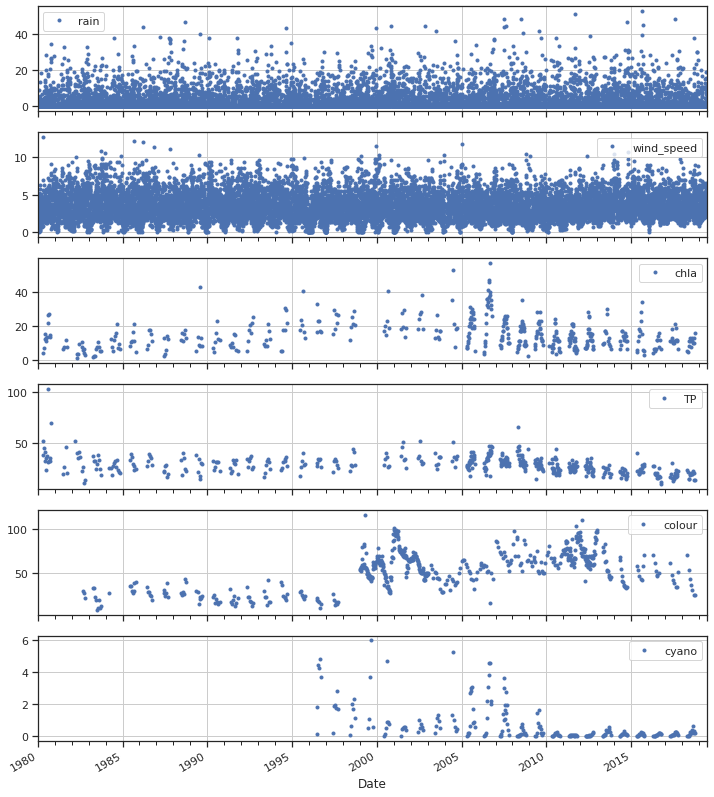

In [40]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

df_list = [met_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Rename some cols
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume',
                   'Cyano_biovol_mm3_per_l':'cyano',
                   'chl-a':'chla'}
daily_df.rename(var_rename_dict, axis=1, inplace=True)

cols_to_keep = ['TP','chla','colour','cyano',
               'rain','wind_speed']

for col in daily_df.columns:
    if col not in cols_to_keep:
        daily_df.drop(col, axis=1, inplace=True)

# Check output
daily_df.head()

daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3,
                                               figsize=(12,15), grid=True);

# Resample to seasonal and tidy

Define two seasons per year. Lake sampling is from mid-April to mid-October, WFD status calculated as the average or maximum observed over the growing season, defined as May-Oct. So use WFD-based season definition of 'summer' vs 'winter'.

In [41]:
agg_method_dict = {'rain': np.nansum,
                   'colour': np.nanmean,
                   'TP': np.nanmean,
                   'chla': np.nanmean,
                   'wind_speed': np.nanmean,
                   'cyano': np.nanmax
                  }

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [11,12,1,2,3,4]:
        return 'wint'
    else:
        return 'summ'

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
# Returns df in which winter values are stored against the year that corresponds to
# the second half of the winter (e.g. Nov 1999 - April 2000 stored as 2000).
season_df = daily_df.resample('2Q-Apr', closed='left').agg(agg_method_dict)

# Remove frequncy info from index so all plotting works right
season_df.index.freq=None

# For summed variables, drop first winter row as missing the first 2 months (regardless of yr)
for col in season_df.columns:
    if agg_method_dict[col] == np.nansum:
        season_df[col].loc['1980-04-30'] = np.NaN

season_df['Season'] = season_df.index.month.map(season)

season_df.head(6)

,rain,colour,TP,chla,wind_speed,cyano,Season
Date,,,,,,,
1980-04-30,NaN,NaN,45.250000,3.971429,2.848333,NaN,wint
1980-10-31,579.570268,NaN,43.573016,16.080130,3.341848,NaN,summ
1981-04-30,244.503965,NaN,NaN,NaN,3.413812,NaN,wint
1981-10-31,494.730157,NaN,28.833333,8.331250,3.488587,NaN,summ
1982-04-30,366.125943,NaN,46.250000,1.100000,3.360221,NaN,wint
1982-10-31,458.474789,26.666667,26.988095,5.975000,3.818478,NaN,summ


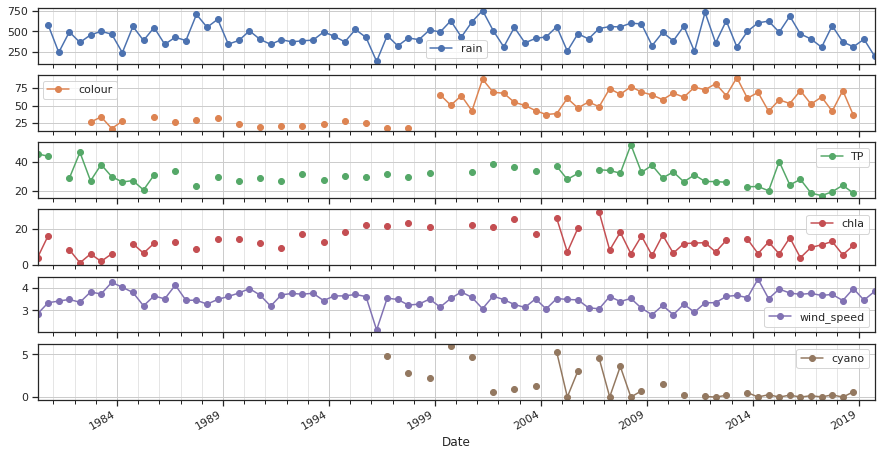

In [42]:
# Quick check of output
ax = season_df.plot(subplots=True, figsize=(15,8), grid=True, marker='o')
for i in range(len(season_df.columns)-1):
    ax[i].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)

In [43]:
# Remove winter rows
summer_df = season_df.loc[season_df['Season']=='summ']
summer_df.drop('Season',axis=1,inplace=True) # No longer need season column

# Add previous summer values for selected cols
prevSummerCols = summer_df[['colour','TP','chla']].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
summer_df = summer_df.join(prevSummerCols)

# Reindex
summer_df['year'] = summer_df.index.year
summer_df.set_index('year', inplace=True)

summer_df.head()

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,,,,,
1980,579.570268,NaN,43.573016,16.080130,3.341848,NaN,NaN,NaN,NaN
1981,494.730157,NaN,28.833333,8.331250,3.488587,NaN,NaN,43.573016,16.08013
1982,458.474789,26.666667,26.988095,5.975000,3.818478,NaN,NaN,28.833333,8.33125
1983,466.631052,17.625000,29.781250,6.050000,4.247283,NaN,26.666667,26.988095,5.97500
1984,561.472065,NaN,27.158333,11.611111,3.796739,NaN,17.625000,29.781250,6.05000


In [45]:
# Patch some NaNs

# Truncate start and end years so covers period 1981-2018 (incl.)
summer_df = summer_df.loc[1981:2018,:]

# Linearly interpolate gaps of size 1
summer_df.interpolate(method='linear',limit=1, inplace=True)

# Backwards fill colour NaNs at start of record (summer colour and previous summer's colour)
for col in ['colour','colour_prevSummer']:
    summer_df[col] = summer_df[col].fillna(method='bfill', limit=1)

summer_df.head()

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,,,,,
1981,494.730157,26.666667,28.833333,8.331250,3.488587,NaN,NaN,43.573016,16.080130
1982,458.474789,26.666667,26.988095,5.975000,3.818478,NaN,26.666667,28.833333,8.331250
1983,466.631052,17.625000,29.781250,6.050000,4.247283,NaN,26.666667,26.988095,5.975000
1984,561.472065,26.014881,27.158333,11.611111,3.796739,NaN,17.625000,29.781250,6.050000
1985,548.374613,34.404762,30.957143,11.895238,3.644022,NaN,26.014881,27.158333,11.611111


In [49]:
# Transform cyano data using boxcox transformation to make ~Gaussian

summer_df_bxcx = summer_df.copy()

for col in ['cyano']:
    summer_df_bxcx[col] = boxcox(summer_df_bxcx[col].values, lmbda=0.1)

In [52]:
# Write to csv
summer_df_bxcx.to_csv(out_file)